<a href="https://colab.research.google.com/github/jujuGthb/Apple_Stock_Price_Prediction_II/blob/main/Custom_Transformer_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Market Trends Using Historical Time Series Data

### Step 1: Data Collection (Scraping from Yahoo Finance)


##### Install yfinance

In [ ]:
!pip install yfinance pytorch-forecasting torch scikit-learn matplotlib pandas



Active code page: 1252


In [ ]:
!pip install --upgrade yfinance


Active code page: 1252


##### Import necessary libraries

In [ ]:
# Required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch import nn
import time

##### Using yfinance for Data Collection


In [ ]:

def download_data_with_retry(ticker, start, end, interval, max_retries=5, delay=5):
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start=start, end=end, interval=interval , auto_adjust=False)


            print("Download successful!")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print("All retry attempts failed.")
    return None

# Define parameters
ticker = 'AAPL'
start_date = '2004-01-01'
end_date = '2024-01-01'
interval = '1d'

# Download data with retry
data = download_data_with_retry(ticker, start_date, end_date, interval)
if data is not None:
    print(data.head())




[*********************100%***********************]  1 of 1 completed

Download successful!
Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2004-01-02  0.320548  0.380000  0.388393  0.378214  0.384821  144642400
2004-01-05  0.333954  0.395893  0.399821  0.382500  0.382500  395018400
2004-01-06  0.332749  0.394464  0.400357  0.387679  0.397321  509348000
2004-01-07  0.340281  0.403393  0.407679  0.391607  0.394643  586874400
2004-01-08  0.351880  0.417143  0.423750  0.404464  0.407857  460303200


##### Check the records number

In [ ]:
if data is not None:
    print(f"Number of records downloaded: {len(data)}")
else:
    print("Data download failed.")


Number of records downloaded: 5033


#####  Rename Columns:

In [ ]:

# After flattening, ensure the number of columns matches the number of new column names
data.columns = ['Adj Close', 'Close', 'High', 'Low', 'open', 'Volume']
data=data.round(2)

 ##### Display the Data

In [ ]:
data.head()

,Adj Close,Close,High,Low,open,Volume
Date,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200


In [ ]:
data.tail()

,Adj Close,Close,High,Low,open,Volume
Date,,,,,,
2023-12-22,192.66,193.60,195.41,192.97,195.18,37122800
2023-12-26,192.11,193.05,193.89,192.83,193.61,28919300
2023-12-27,192.21,193.15,193.50,191.09,192.49,48087700
2023-12-28,192.64,193.58,194.66,193.17,194.14,34049900
2023-12-29,191.59,192.53,194.40,191.73,193.90,42628800


In [ ]:



# SMA and EMA
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Daily Returns
data['Daily_Return'] = data['Close'].pct_change() * 100

# Add Volatility (rolling standard deviation) to the DataFrame
data['Volatility_20'] = data['Close'].rolling(window=20).std()



data.head(20)

,Adj Close,Close,High,Low,open,Volume,SMA_50,EMA_50,Daily_Return,Volatility_20
Date,,,,,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400,NaN,0.380000,NaN,NaN
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400,NaN,0.380784,5.263158,NaN
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000,NaN,0.381146,-2.500000,NaN
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400,NaN,0.381885,2.564103,NaN
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200,NaN,0.383380,5.000000,NaN
2004-01-09,0.35,0.41,0.43,0.41,0.41,427459200,NaN,0.384424,-2.380952,NaN
2004-01-12,0.36,0.42,0.43,0.41,0.42,487547200,NaN,0.385819,2.439024,NaN
2004-01-13,0.36,0.43,0.44,0.43,0.44,679016800,NaN,0.387551,2.380952,NaN
2004-01-14,0.36,0.43,0.44,0.42,0.44,620043200,NaN,0.389216,0.000000,NaN


#####  Save the data to a CSV file

In [ ]:
data.to_csv('AAPL_stock_data.csv')

####  Step 2 :  Data Preprocessing

In [ ]:

# Load the data
data = pd.read_csv('AAPL_stock_data.csv', parse_dates=['Date'], index_col='Date')

# Inspect the data
print(data.info())  # Check for missing values, column types, etc.

# Check for missing values
print(data.isnull().sum())

# Handle missing values using back fill
data = data.bfill()

# Display first 10 rows
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2004-01-02 to 2023-12-29
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close      5033 non-null   float64
 1   Close          5033 non-null   float64
 2   High           5033 non-null   float64
 3   Low            5033 non-null   float64
 4   open           5033 non-null   float64
 5   Volume         5033 non-null   int64  
 6   SMA_50         4984 non-null   float64
 7   EMA_50         5033 non-null   float64
 8   Daily_Return   5032 non-null   float64
 9   Volatility_20  5014 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 432.5 KB
None
Adj Close         0
Close             0
High              0
Low               0
open              0
Volume            0
SMA_50           49
EMA_50            0
Daily_Return      1
Volatility_20    19
dtype: int64


,Adj Close,Close,High,Low,open,Volume,SMA_50,EMA_50,Daily_Return,Volatility_20
Date,,,,,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400,0.4196,0.380000,5.263158,0.012183
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400,0.4196,0.380784,5.263158,0.012183
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000,0.4196,0.381146,-2.500000,0.012183
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400,0.4196,0.381885,2.564103,0.012183
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200,0.4196,0.383380,5.000000,0.012183
2004-01-09,0.35,0.41,0.43,0.41,0.41,427459200,0.4196,0.384424,-2.380952,0.012183
2004-01-12,0.36,0.42,0.43,0.41,0.42,487547200,0.4196,0.385819,2.439024,0.012183
2004-01-13,0.36,0.43,0.44,0.43,0.44,679016800,0.4196,0.387551,2.380952,0.012183
2004-01-14,0.36,0.43,0.44,0.42,0.44,620043200,0.4196,0.389216,0.000000,0.012183


#### Step 3 : Exploratory Data Analysis (EDA)

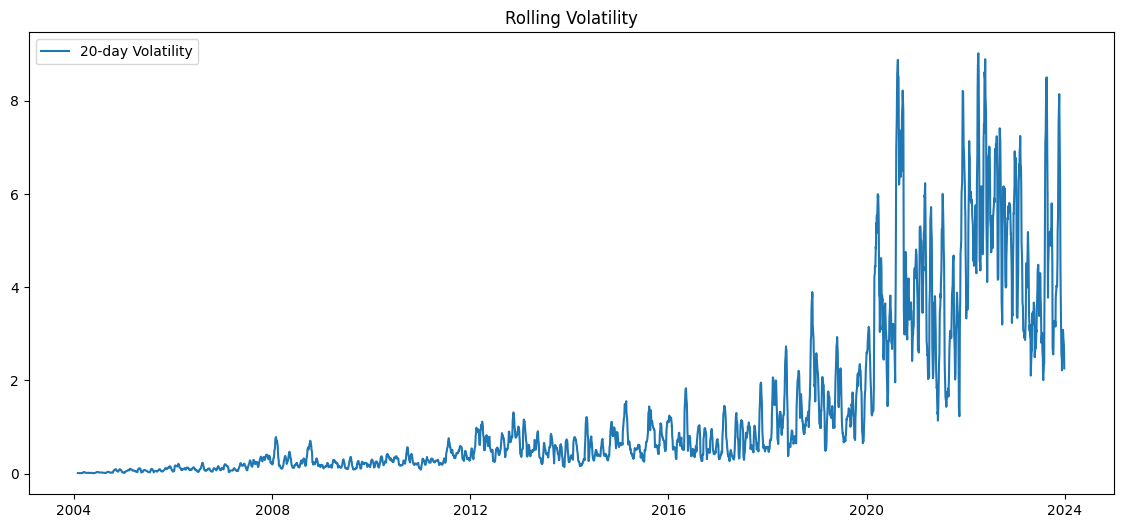

In [ ]:
# Rolling volatility
data['Volatility'] = data['Close'].rolling(window=20).std()
plt.figure(figsize=(14, 6))
plt.plot(data['Volatility'], label='20-day Volatility')
plt.title("Rolling Volatility")
plt.legend()
plt.show()



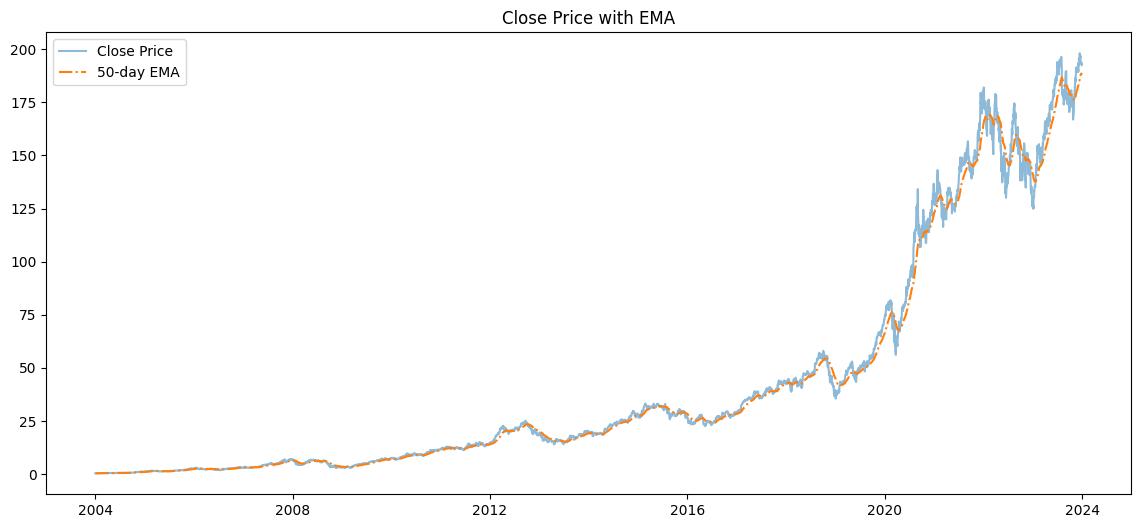

In [ ]:
# Visualize SMA and EMA
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['EMA_50'], label='50-day EMA', linestyle='-.')
plt.title("Close Price with EMA")
plt.legend()
plt.show()

####  Feature Engineering

In [ ]:
# Load and scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'SMA_50', 'EMA_50', 'Daily_Return', 'Volatility_20']])
data_scaled = pd.DataFrame(scaled_data, columns=['Close', 'SMA_50', 'EMA_50', 'Daily_Return', 'Volatility_20'], index=data.index)

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled.iloc[i-sequence_length:i].values)
    y.append(data_scaled.iloc[i, 0])  # Target is 'Close'
X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


#### building the model

In [ ]:
# Custom Transformer Model
class CustomTransformer(nn.Module):
    def __init__(self, input_dim, seq_len, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(CustomTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(seq_len * input_dim, 1)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # (seq_len, batch, input_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2).reshape(x.size(1), -1)  # (batch, seq_len * input_dim)
        x = self.fc(x)
        return x

# Initialize model
custom_model = CustomTransformer(
    input_dim=5,  # Matches the feature count in X_train_tensor
    seq_len=sequence_length,
    num_heads=1,  # Adjusted to ensure input_dim is divisible by num_heads
    num_layers=2,
    hidden_dim=64,
    dropout=0.2
)


C:\Users\ThinkPad\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


#### function of training the model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=10):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses = []  # To track training loss
    val_losses = []    # To track validation loss

    start_time = time.time()  # Start timing
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Log training loss
        train_losses.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        # Log epoch details
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    training_time = time.time() - start_time  # Calculate training time

    # Plot epoch vs. loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', linestyle='-')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs. Loss')
    plt.legend()
    plt.show()

    print(f"Total Training Time: {training_time:.2f} seconds")
    return model, train_losses, val_losses

#### function of evaluating the model

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    start_time = time.time()  # Start timing for inference
    with torch.no_grad():
        predictions = model(X_test).squeeze().numpy()
    inference_time = time.time() - start_time  # Calculate inference time

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        nonzero_indices = y_true != 0  # Avoid division by zero
        return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

    mape = mean_absolute_percentage_error(y_test, predictions)

    print(f"Inference Time: {inference_time:.2f} seconds")
    return predictions, {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape}


#### Training the model


Epoch 1/50, Training Loss: 0.3648, Validation Loss: 0.2195
Epoch 2/50, Training Loss: 0.2373, Validation Loss: 0.1994
Epoch 3/50, Training Loss: 0.2151, Validation Loss: 0.1672
Epoch 4/50, Training Loss: 0.1787, Validation Loss: 0.1217
Epoch 5/50, Training Loss: 0.1391, Validation Loss: 0.0793
Epoch 6/50, Training Loss: 0.0961, Validation Loss: 0.0509
Epoch 7/50, Training Loss: 0.0706, Validation Loss: 0.0387
Epoch 8/50, Training Loss: 0.0570, Validation Loss: 0.0356
Epoch 9/50, Training Loss: 0.0541, Validation Loss: 0.0311
Epoch 10/50, Training Loss: 0.0469, Validation Loss: 0.0220
Epoch 11/50, Training Loss: 0.0379, Validation Loss: 0.0123
Epoch 12/50, Training Loss: 0.0274, Validation Loss: 0.0081
Epoch 13/50, Training Loss: 0.0221, Validation Loss: 0.0104
Epoch 14/50, Training Loss: 0.0264, Validation Loss: 0.0141
Epoch 15/50, Training Loss: 0.0284, Validation Loss: 0.0146
Epoch 16/50, Training Loss: 0.0276, Validation Loss: 0.0119
Epoch 17/50, Training Loss: 0.0253, Validation Lo

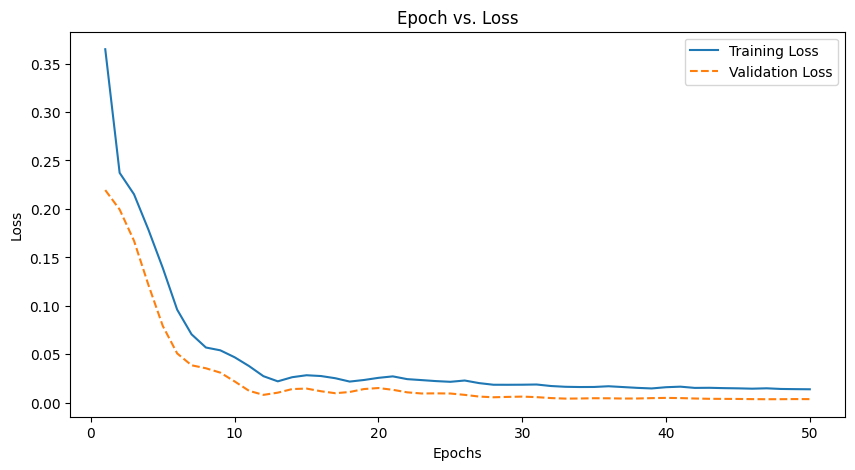

Total Training Time: 80.29 seconds
Inference Time: 0.10 seconds
Evaluation Metrics: {'MSE': 0.0037345708317128115, 'MAE': 0.034200108400099495, 'RMSE': np.float64(0.061111135087746585), 'R2': 0.9487773359939471, 'MAPE': np.float64(65.89157446419968)}


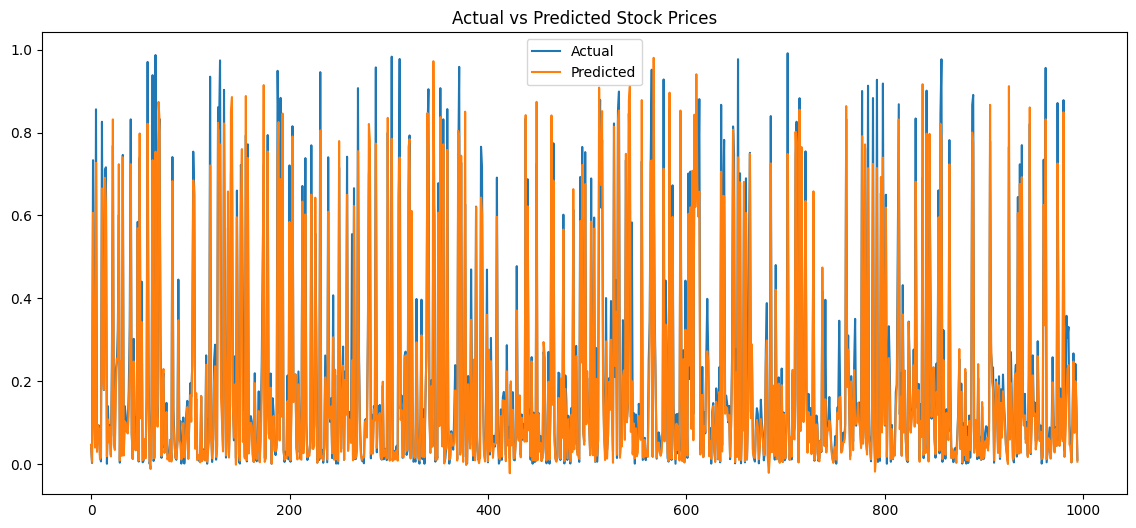

In [ ]:
# Train the model
trained_model, train_losses, val_losses = train_model(
    custom_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=50
)

# Evaluate the model
predictions, metrics = evaluate_model(trained_model, X_test_tensor, y_test)

# Print metrics
print("Evaluation Metrics:", metrics)

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

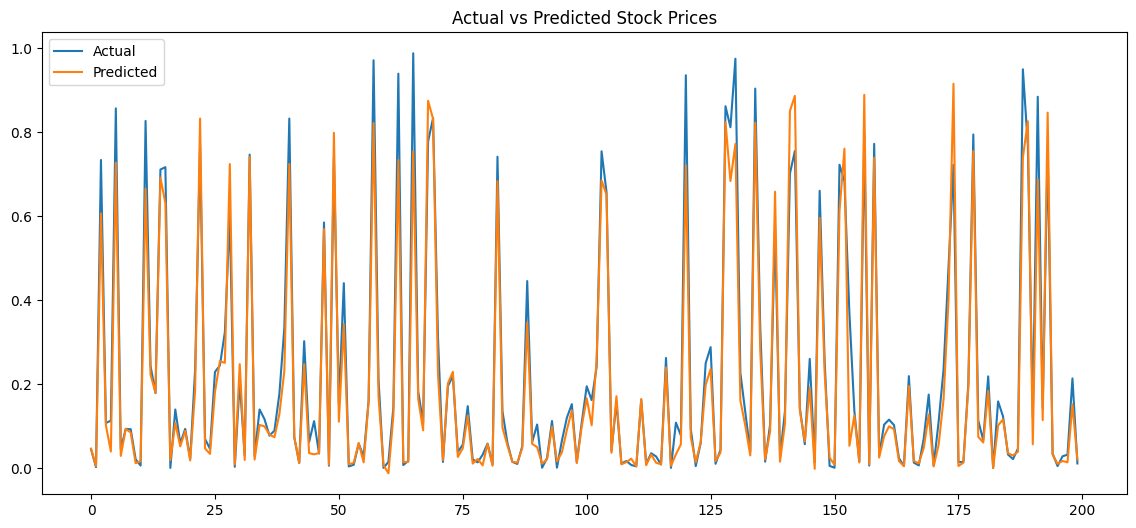

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200], label='Actual')
plt.plot(predictions[:200], label='Predicted')
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()